In [6]:
import torch
import torch.nn
import torchvision
import torch.utils.data.dataloader
print(torch.__version__)
print(torch.cuda.is_available())
import matplotlib.pyplot as plt


1.10.2
True


In [7]:
batch_size_train = 32
batch_size_test = 256
train_loader = torch.utils.data.DataLoader(
    torchvision.datasets.MNIST('./data/', train=True, download=True,
                               transform=torchvision.transforms.Compose([
                                   torchvision.transforms.ToTensor(),
                                   torchvision.transforms.Normalize(
                                       (0.1307,), (0.3081,))
                               ])),
    batch_size=batch_size_train, shuffle=True)
test_loader = torch.utils.data.DataLoader(
    torchvision.datasets.MNIST('./data/', train=False, download=True,
                               transform=torchvision.transforms.Compose([
                                   torchvision.transforms.ToTensor(),
                                   torchvision.transforms.Normalize(
                                       (0.1307,), (0.3081,))
                               ])),
    batch_size=batch_size_test, shuffle=True)


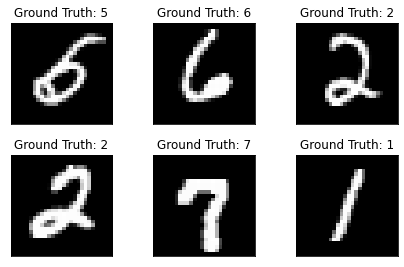

In [8]:
examples = enumerate(test_loader)
batch_idx, (example_data, example_targets) = next(examples)
fig = plt.figure()
for i in range(6):
  plt.subplot(2,3,i+1)
  plt.tight_layout()
  plt.imshow(example_data[i][0], cmap='gray', interpolation='none')
  plt.title("Ground Truth: {}".format(example_targets[i]))
  plt.xticks([])
  plt.yticks([])
plt.show()

In [ ]:
class MLP(torch.nn.Module):
    def __init__(self) -> None:
        super(MLP, self).__init__()
        self.model = torch.nn.Sequential(
            torch.nn.Linear(784, 256),
            torch.nn.LeakyReLU(inplace=True),
            torch.nn.Linear(256, 64),
            torch.nn.LeakyReLU(inplace=True),
            torch.nn.Linear(64, 10)
        )
    def forward(self,x):
        x = self.model(x)
        return x
epochs = 100
cuda = torch.device('cuda:0')
learning_rate = 0.001
net = MLP().to(cuda)
opt = torch.optim.SGD(net.parameters(), lr=learning_rate)
loss_func = torch.nn.CrossEntropyLoss().to(cuda)
for epoch in range(epochs):
    net.train()
    for batch_idx, (data, target) in enumerate(train_loader):
        data = data.view(-1, 28*28)
        data, target = data.to(cuda), target.to(cuda)
        output = net(data)
        loss = loss_func(output, target)
        opt.zero_grad()
        loss.backward()
        opt.step()
        if batch_idx % 1000 == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, batch_idx * len(data), len(train_loader.dataset),
                100. * batch_idx  / len(train_loader), loss.item()
            ))
    with torch.no_grad():
        correct_nums = 0
        total_nums = 0
        net.eval()
        for data, target in test_loader:
            data = data.view(-1, 28*28)
            data, target = data.to(cuda), target.to(cuda)
            data = net(data)
            pred = data.argmax(dim=1)
            correct_nums += torch.eq(pred, target).float().sum().item()
            total_nums += data.size(0)
        accuracy = correct_nums / total_nums
        print("epoch: {}\tloss: {}\taccuracy: {}".format(epoch, loss.item(), accuracy))
